# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

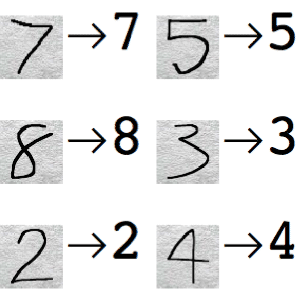

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

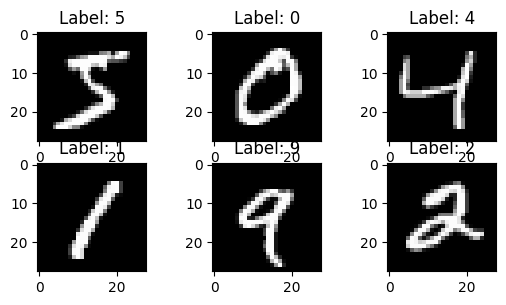

In [16]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True
)
# Vẽ một vài hình ảnh đầu tiên
for i in range(6):
    # Định nghĩa subplot
    plt.subplot(330 + 1 + i)
    # Vẽ dữ liệu pixel thô
    plt.imshow(train_dataset.data[i], cmap='gray')
    # Đặt tiêu đề cho hình ảnh
    plt.title(f'Label: {train_dataset.targets[i].item()}')

# Hiển thị hình ảnh
plt.show()

## Define Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset

## Load Dataset

- Các ảnh đều cùng kích thước hình vuông là 28×28 pixel và có thang độ xám. Do đó, Ta có thể tải ảnh và định hình lại mảng dữ liệu để có một kênh màu duy nhất.
- Dùng one hot encoding một lần cho phần tử lớp của mỗi mẫu, chuyển đổi số nguyên thành vectơ nhị phân 10 phần tử với 1 cho chỉ mục của giá trị lớp và giá trị 0 cho tất cả các lớp khác


In [17]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [3]:
def load_dataset():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

## Prepare Pixel Data

- Các giá trị pixel mỗi ảnh trong tập dữ liệu là các số nguyên không dấu trong phạm vi từ đen và trắng hoặc 0 đến 255.

- Điểm khởi đầu tốt là chuẩn hóa các giá trị pixel của ảnh thang độ xám, ví dụ: thay đổi tỷ lệ chúng thành phạm vi [0,1]. Điều này trước tiên bao gồm việc chuyển đổi kiểu dữ liệu từ số nguyên không dấu sang số float, sau đó chia giá trị pixel cho giá trị tối đa.

In [4]:
def prep_pixels(train, test):
    return train.data.float() / 255.0, test.data.float() / 255.0

## Define Model



In [95]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(64 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [96]:
# Khởi tạo mô hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

## Training Mode && Testing

In [97]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loaders['train'])

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    avg_test_loss = test_loss / len(loaders['test'])
    accuracy = 100. * correct / len(loaders['test'].dataset)
    return avg_test_loss, accuracy

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(train_losses, test_losses, test_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    images, labels = next(iter(test_loader))  # Lấy một batch hình ảnh
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        plt.title(f'Predicted: {predicted[i].item()}\nTrue: {labels[i].item()}')
        plt.axis('off')
    plt.show()

## Evaluate && Summarize Model

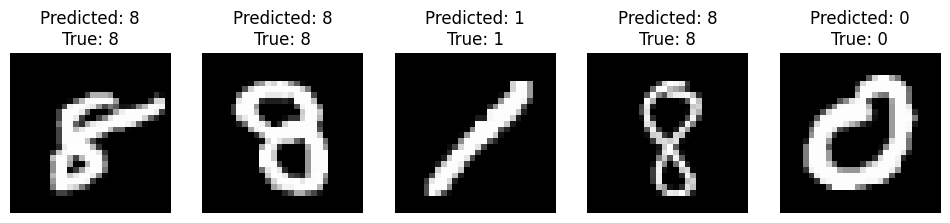

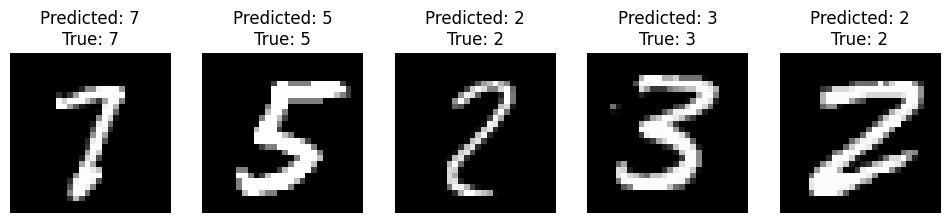

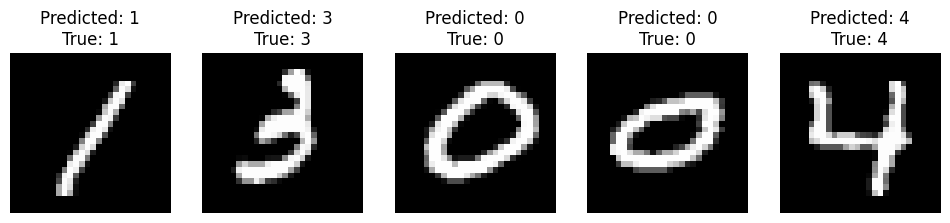

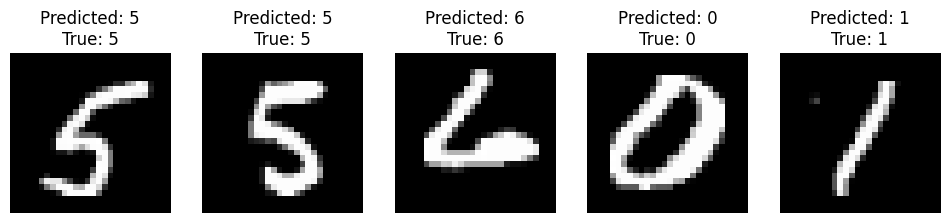

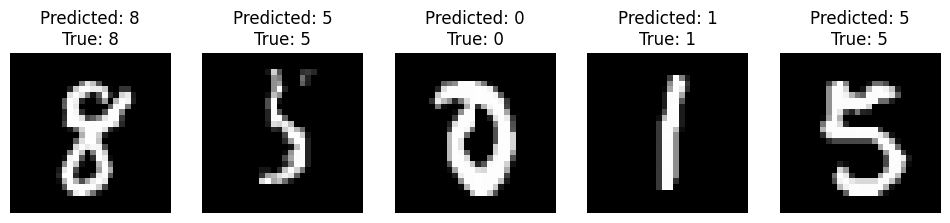

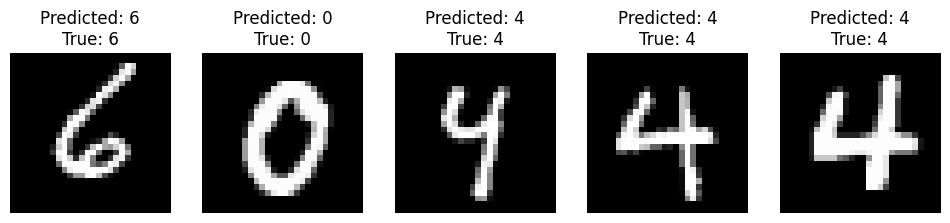

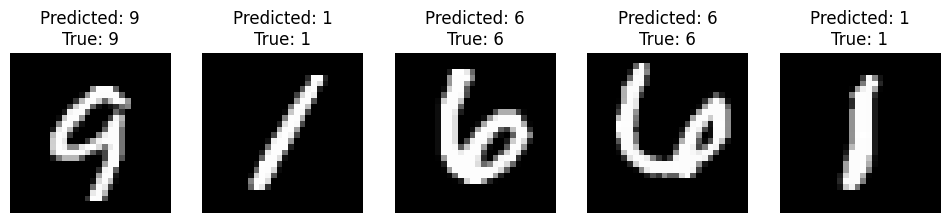

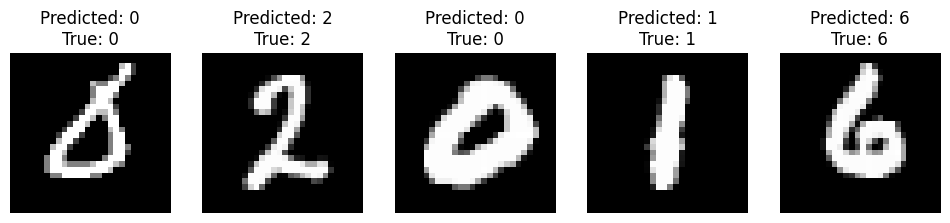

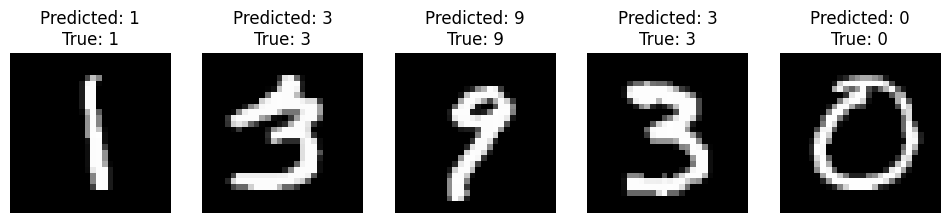

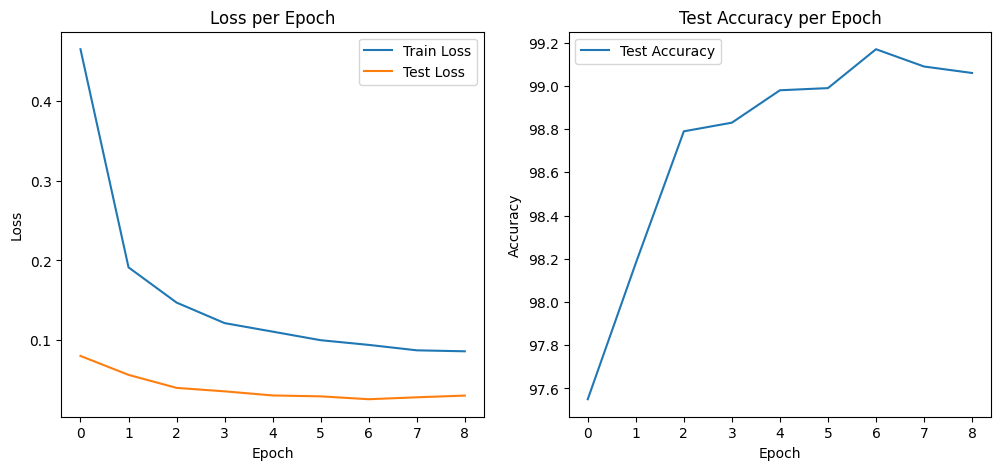

In [99]:
# Huấn luyện và đánh giá mô hình
train_losses, test_losses, test_accuracies = [], [], []

for epoch in range(1, 10):
    train_loss = train(epoch)
    test_loss, test_accuracy = test()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Hiển thị hình ảnh dự đoán sau mỗi epoch
    visualize_predictions(model, loaders['test'])

# Vẽ kết quả
plot_results(train_losses, test_losses, test_accuracies)

## Prediction

In [48]:
import matplotlib.pyplot as plt
from PIL import Image

# Hàm dự đoán
def predict_image(model, image_path):
    image = Image.open(image_path).convert('L')  # Chuyển sang grayscale
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = transform(image).unsqueeze(0).to(device)  # Thêm chiều batch

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item(), image

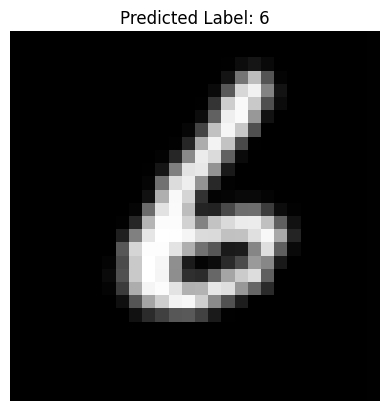

In [49]:
# Sử dụng hàm dự đoán
image_path = '/content/6.png'
predicted_label, image = predict_image(model, image_path)

# Hiển thị hình ảnh và nhãn dự đoán
plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()